**Problem 3**

In [1]:

# Useful additional packages 
import matplotlib.pyplot as plt
import numpy as np
from math import pi

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.tools.visualization import circuit_drawer
from qiskit.quantum_info import state_fidelity
from qiskit import BasicAer
from qiskit.quantum_info import Operator
from qiskit.quantum_info import Statevector
import torch




"""
q = QuantumRegister(2)

qc = QuantumCircuit(q)
qc.u(pi,0,pi,q[0])
qc.draw()
"""


#lets create GHZ state
circ = QuantumCircuit(3)
# Add a H gate on qubit 0, putting this qubit in superposition.
circ.h(0)
# Add a CX (CNOT) gate on control qubit 0 and target qubit 1, putting
# the qubits in a Bell state.
circ.cx(0, 1)
# Add a CX (CNOT) gate on control qubit 0 and target qubit 2, putting
# the qubits in a GHZ state.
circ.cx(0, 2)
# Set the intial state of the simulator to the ground state using from_int
state = Statevector.from_int(0, 2**3)
state1 = state.copy()
# Evolve the state by the quantum circuit
state = state.evolve(circ)
print(state)
print(state1)

Statevector([0.70710678+0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.70710678+0.j],
            dims=(2, 2, 2))
Statevector([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j],
            dims=(2, 2, 2))


In [2]:
#function that apply the KS test to two probability list
def KS(P1, P2):
    assert len(P1) == len(P2)
    cdf1 = [P1[0]]
    cdf2 = [P2[0]]
    for i in range(len(P1)-1):
        cdf1.append(cdf1[i] + P1[i+1])
        cdf2.append(cdf2[i] + P2[i+1])
    difference = torch.tensor(cdf1) - torch.tensor(cdf2)
    #print(difference)
    return difference.abs().max().item()
"""
def KS(P1, P2):
    P1 = torch.tensor(P1)
    P2 = torch.tensor(P2)
    return torch.pow(P1 - P2, 2).sum() / P1.size(0)
"""
#print(KS([0.2, 0.8], [0.5, 0.5]))


def KL(P1, P2):
    Q = torch.tensor(P1)
    Q = Q + 0.00001 * torch.ones(Q.size())
    P = torch.tensor(P2)
    P = P + 0.00001 * torch.ones(Q.size())
    #print(Q)
    #tens = torch.div(P, Q)
    #tens = 
    return (torch.log(torch.div(P, Q)) * P).sum().item()

print(KL([0, 1], [0.5, 0.5]))




def gauss(x,y, s):
    return torch.exp(-torch.abs(torch.tensor(x-y))**2/(2*s**2))
def MMDLoss(sampX, sampY, s):
    '''Computing MMD loss out of samples'''
    mmd = 0
    if len(sampX)!=len(sampY): raise ValueError('Length of samples does not match')
    L=len(sampX)
    for i in range(L):
        for j in range(L):
            mmd += gauss(sampX[i], sampX[j], s)
            mmd += gauss(sampY[i], sampY[j], s)
            mmd -= 2*gauss(sampX[i], sampY[j], s)
    return mmd/L**2

import numpy as np
def mmdloss(P1, P2):
    #first create the list of probability distribution
    sample1 = np.random.choice(len(P1), size=100, p=P1)
    sample2 = np.random.choice(len(P2), size=100, p=P2)
    #print(sample1)
    #print(sample2)
    return MMDLoss(sample1, sample2, 1).item()

print(mmdloss([0,0, 1], [1,0, 0]))



5.063431739807129
1.7293943166732788


In [3]:
from torch.nn import functional as F
import torch.nn as nn

#This is our KS network duh
class KS_net(nn.Module):
    def __init__(self):
        super(KS_net, self).__init__()
        self.linear1 = nn.Linear(9, 20)
        self.linear2 = nn.Linear(20, 20)
        self.linear3 = nn.Linear(20, 1)
    
    def forward(self, param):
        x = F.relu(self.linear1(param))
        #print(x)
        x = F.relu(self.linear2(x))
        #print(x)
        x = F.relu(self.linear3(x))
        return x

tensor(34129.9453)
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


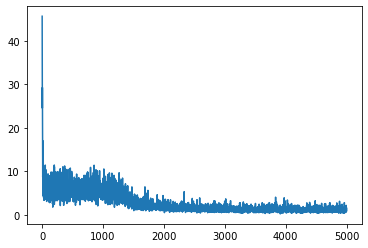

tensor(10218.3086)


In [4]:
#this is where we try to learn the symmetry
import random

class SymFinder():
  def __init__(self, eta, step_size, training_length):
    self.parameters = torch.randint(0, 100, (3, 3)) * pi /100
    #parameters[i,0] is the theta for ith qubit, 1 is \phi, 2 is lambda
    self.original_state = state
    self.transformed_state = None
    self.param_rate = eta # this is the learning rate for updating parameter
    self.step_size = step_size
    self.losses = []
    self.known_symmetries = []
    self.prob_metric = KL

    #now these are the nn attributes
    self.train_data = torch.zeros(5000, 10) #data for training KS_net, 9 + 1 = param + value
    self.train_data.requires_grad = False
    self.test_data = torch.zeros(1000, 10)
    self.learn_rate = 0.01 #learning rate for training KS_net
    self.model = KS_net()
    self.batch_size = 20 #batch for SGD
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr = self.learn_rate)
    self.loss_func = nn.MSELoss()
    self.memory_pointer = 0 #tell where to store new data
    self.valid_range = 0#how much valid data is in the tensor, dont want to learn 00000
    self.training_length = training_length



  
  #return a transformed state according to parameter
  def transform(self, p):
    q = QuantumRegister(3)
    qc = QuantumCircuit(q)
    qc.u(p[0,0].item(),p[0,1].item(),p[0,2].item(),q[0])
    qc.u(p[1,0].item(),p[1,1].item(),p[1,2].item(),q[1])
    qc.u(p[2,0].item(),p[2,1].item(),p[2,2].item(),q[2])
    return self.original_state.copy().evolve(qc)


  
  def change_basis(self, state1, state2):
    q = QuantumRegister(3)
    qc = QuantumCircuit(q)
    qc.u(0*pi/30, 0, 0, q[0])
    qc.u(1*pi/10, 0, 0, q[1])
    qc.u(0*pi/30, 0, 0, q[2])
    return state1.copy().evolve(qc), state2.copy().evolve(qc)

  #return the loss from KS test of original vs another state
  def calculate_loss(self, state2, param):
    #get the probability in the original basis
    P1 = self.original_state.probabilities()
    P2 = state2.probabilities()
    #now we calculate probability in another basis
    new_state1, new_state2 = self.change_basis(self.original_state, state2)
    Q1 = new_state1.probabilities()
    Q2 = new_state2.probabilities()
    return [self.prob_metric(P1, P2) + 0 * self.prob_metric(Q1, Q2), 0 * self.prob_metric(P1, P2) + 1*self.prob_metric(Q1, Q2)]
  

  def generate_data(self):
    #generate the test data and train data
    for i in range(self.test_data.size(0)):
      parameters = torch.randint(0, 200, (3, 3)) * 2 * pi / 200
      #parameters[2:3, :] = torch.zeros(1,3)
      target = torch.tensor([self.calculate_loss(self.transform(parameters), parameters)[1]])
      self.test_data[i, 0:9] = parameters.view(9)
      self.test_data[i, 9] = target
    for i in range(self.train_data.size(0)):
      parameters = torch.randint(0, 200, (3, 3)) * 2 * pi / 200
      #parameters[2:3, :] = torch.zeros(1,3)
      target = torch.tensor([self.calculate_loss(self.transform(parameters), parameters)[1]])
      self.train_data[i, 0:9] = parameters.view(9)
      self.train_data[i, 9] = target




  def train_KS_net(self):
    #this function use the data gathered to update KS_net parameters
    for i in range(self.training_length):
      self.optimizer.zero_grad()
      num = self.train_data.size(0)
      indices = random.sample(range(num), self.batch_size)
      sampled_data = self.train_data[indices].clone()
      target = sampled_data[:, 9] #actual KS_value
      current = self.model(sampled_data[:, 0:9]).squeeze()
      loss = self.loss_func(current, target)
      self.losses.append(loss.item())
      #print(loss)
      loss.backward()
      self.optimizer.step()
      if i % 100 == 0:
        print(i)
      
  def test_error(self):
    current = self.model(self.test_data[:, 0:9]).detach_()
    target = self.test_data[:, 9]
    return torch.pow(current- target, 2).sum() / current.size(0)



  def current_matrix(self):
    p = self.parameters
    #p[0,:] = torch.tensor([3.14159, 0,3.1415926])
    u0 = torch.tensor([[torch.cos(p[0,0]/2), -torch.exp(-p[0,2]*1j)*torch.sin(p[0,0]/2)],\
                    [torch.exp(p[0,1]*1j)*torch.sin(p[0,0]/2), torch.exp((p[0,1] + p[0,2])*1j)*torch.cos(p[0,0]/2)]])
    u1 = torch.tensor([[torch.cos(p[1,0]/2), -torch.exp(-p[1,2]*1j)*torch.sin(p[1,0]/2)],\
                    [torch.exp(p[1,1]*1j)*torch.sin(p[1,0]/2), torch.exp((p[1,1] + p[1,2])*1j)*torch.cos(p[1,0]/2)]])
    u2 = torch.tensor([[torch.cos(p[2,0]/2), -torch.exp(-p[2,2]*1j)*torch.sin(p[2,0]/2)],\
                    [torch.exp(p[2,1]*1j)*torch.sin(p[2,0]/2), torch.exp((p[2,1] + p[2,2])*1j)*torch.cos(p[2,0]/2)]])
    return [u0, u1, u2]
        
        
        
        

import numpy as np

finder = SymFinder(0.05, 0.01, 5000)
finder.generate_data()
print(finder.test_error())
finder.train_KS_net()
plt.plot(range(len(finder.losses)), finder.losses)

plt.show()
print(finder.test_error())


  

  
  
  

  


In [5]:
from torch.nn import functional as F
import torch.nn as nn

#This is our KS network duh
class KS_net(nn.Module):
    def __init__(self):
        super(KS_net, self).__init__()
        self.linear1 = nn.Linear(9, 100)
        self.linear2 = nn.Linear(100, 100)
        self.linear3 = nn.Linear(100, 100)
        self.linear4 = nn.Linear(100, 1)
    
    def forward(self, param):
        x = F.relu(self.linear1(param))
        #print(x)
        x = F.relu(self.linear2(x))
        #print(x)
        x = F.relu(self.linear3(x))
        x = F.relu(self.linear4(x))
        return x

tensor([[3.3929, 2.2619, 0.2199,  ..., 0.0314, 5.8434, 2.8058],
        [1.1310, 1.5394, 5.7177,  ..., 4.6810, 1.4765, 5.8591],
        [4.2097, 6.0319, 4.0841,  ..., 2.0735, 3.6757, 4.8858],
        ...,
        [2.8274, 2.9531, 0.1257,  ..., 2.2934, 6.1575, 1.6219],
        [6.1261, 1.6965, 3.3929,  ..., 1.0053, 4.1783, 8.6865],
        [0.1571, 4.8381, 5.8434,  ..., 1.8221, 5.9690, 8.7600]])
tensor([0.]) tensor(5.0681)
tensor([0.]) tensor(4.9635)
tensor([0.]) tensor(5.4999)
tensor([0.]) tensor(9.1198)
tensor([0.]) tensor(10.3363)
tensor([0.]) tensor(4.8039)
tensor([0.]) tensor(3.4081)
tensor([0.]) tensor(7.4659)
tensor([0.]) tensor(6.0823)
tensor([0.]) tensor(5.0739)
tensor(34207.1211)
tensor(34207.1211)
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


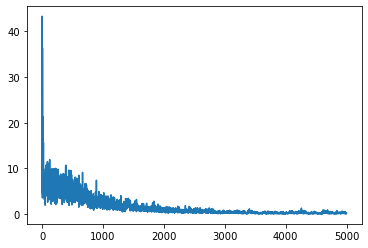

tensor(11386.1963)
tensor([5.7992]) tensor(5.0681)
tensor([5.7734]) tensor(4.9635)
tensor([5.1422]) tensor(5.4999)
tensor([9.8244]) tensor(9.1198)
tensor([9.8821]) tensor(10.3363)
tensor([4.8946]) tensor(4.8039)
tensor([4.3807]) tensor(3.4081)
tensor([7.8294]) tensor(7.4659)
tensor([6.4821]) tensor(6.0823)
tensor([5.3970]) tensor(5.0739)


In [6]:
trainer = SymFinder(1,1, 5000)
trainer.train_data = finder.train_data[0: 2000, :]
print(finder.train_data)
trainer.test_data = finder.test_data
trainer.learn_rate = 0.00
for i in range(10):
    print(trainer.model(trainer.test_data[i, 0: 9]).detach_(), trainer.test_data[i, 9])


print(trainer.test_error())
current = trainer.model(trainer.test_data[:, 0:9]).detach_()
target = trainer.test_data[:, 9]
print(torch.pow(current- target, 2).sum() / current.size(0))


trainer.train_KS_net()
plt.plot(range(len(trainer.losses)),trainer.losses)
plt.show()
print(trainer.test_error())

for i in range(10):
    print(trainer.model(trainer.test_data[i, 0: 9]).detach_(), trainer.test_data[i, 9])


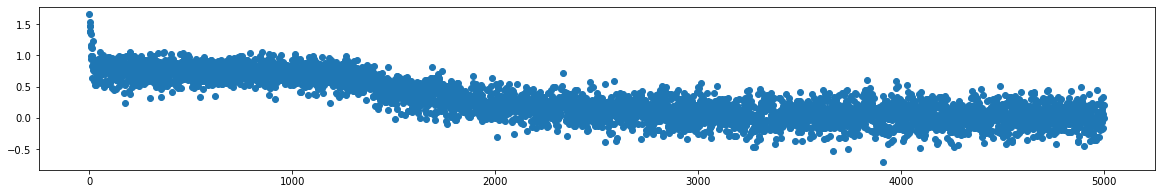

4.802395476318742
tensor([4.7804])
---
4.710172937901108
tensor([6.5292])
---
9.850741329230473
tensor([8.1021])
---
5.195282849179186
tensor([3.3412])
---
4.796499923536821
tensor([4.7009])
---
0.6668886889196228
tensor([1.3645])
---
5.305336497341016
tensor([5.4138])
---
10.352713557697786
tensor([10.2802])
---
4.031338986415175
tensor([3.1215])
---
3.38454838365268
tensor([3.1455])
---


In [7]:
plt.figure(figsize=(20, 3))

plt.scatter(range(len(finder.losses)), np.log10(finder.losses))

plt.show()


def matrix(p):
    #p[0,:] = torch.tensor([3.14159, 0,3.1415926])
    u0 = torch.tensor([[torch.cos(p[0,0]/2), -torch.exp(-p[0,2]*1j)*torch.sin(p[0,0]/2)],\
                    [torch.exp(p[0,1]*1j)*torch.sin(p[0,0]/2), torch.exp((p[0,1] + p[0,2])*1j)*torch.cos(p[0,0]/2)]])
    u1 = torch.tensor([[torch.cos(p[1,0]/2), -torch.exp(-p[1,2]*1j)*torch.sin(p[1,0]/2)],\
                    [torch.exp(p[1,1]*1j)*torch.sin(p[1,0]/2), torch.exp((p[1,1] + p[1,2])*1j)*torch.cos(p[1,0]/2)]])
    u2 = torch.tensor([[torch.cos(p[2,0]/2), -torch.exp(-p[2,2]*1j)*torch.sin(p[2,0]/2)],\
                    [torch.exp(p[2,1]*1j)*torch.sin(p[2,0]/2), torch.exp((p[2,1] + p[2,2])*1j)*torch.cos(p[2,0]/2)]])
    return [u0, u1, u2]


for i in range(10):
    parameters = torch.randint(0, 100, (3, 3)) * 2 * pi /100
    state2 = finder.transform(parameters)
    print
    print(finder.calculate_loss(state2, parameters)[1])
    print(finder.model(parameters.view(9)).detach_())
    print("---")


for p in finder.known_symmetries:
    print(matrix(p)[0])
    print(matrix(p)[1])
    print(matrix(p)[2])
    print("---")

In [8]:
print(torch.exp(torch.tensor([3+3j]))

SyntaxError: unexpected EOF while parsing (<ipython-input-8-31d575f077ea>, line 1)